In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import skimage.io
import pickle
import itertools
import random

from keras.models import Model, load_model, model_from_json
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Flatten, Dense, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import imgaug as ia
from imgaug import augmenters as iaa

sys.path.append(r'C:\Users\nimro\Documents\Python Scripts')
import img_utils

%matplotlib inline

# Paths and Constants

In [ ]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_CHANNELS = 1
NUM_CLASSES = 10
IMG_PATH = r'C:\Users\nimro\Documents\Data\FashionMnist'
LBL_PATH = r'C:\Users\nimro\Documents\Data\FashionMnist'

# Load and orgenize the data

In [ ]:
"""read csv to numpy arrays"""
dfTrain = pd.read_csv(os.path.join(IMG_PATH, 'fashion-mnist_train.csv'))
dfTest = pd.read_csv(os.path.join(IMG_PATH, 'fashion-mnist_test.csv'))

rawTrainLabels = dfTrain.as_matrix(columns=dfTrain.columns[0:1])
Y_test = dfTest.as_matrix(columns=dfTest.columns[0:1])
Y_train = to_categorical(rawTrainLabels)

X_train = dfTrain.as_matrix(columns=dfTrain.columns[1:]).astype(np.uint8)
X_train = X_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
X_test = dfTest.as_matrix(columns=dfTrain.columns[1:])
X_test = X_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

X_train_after_split, X_val, Y_train_after_split, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42)

# Classes handling
originalClasses = {
    0: 'T-Shirt \ Top', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat',
    5: 'Sandal', 
    6: 'Shirt', 
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle boot'
}

# Data Exploration

In [ ]:
def showRandomDataFromFolder(dirpath, numOfFigs=10):
    list_of_images_names = os.listdir(dirpath)
    list_of_images = []
    fig, axes = plt.subplots(1, numOfFigs, figsize=(30, 10))
    for i in range(0, numOfFigs):
        index = random.randint(0, len(list_of_images_names))
        list_of_images.append(skimage.io.imread(os.path.join(dirpath, list_of_images_names[index])))
        axes[i].imshow(list_of_images[i], cmap='gray')
        axes[i].axis('off')
		
    plt.tight_layout()
    plt.show()

    return list_of_images


def showRandomDataFromArray(input_array, numOfFigs=10, labels=None, cls=None):
    fig, axes = plt.subplots(1, numOfFigs, figsize=(30, 10))
    for i in range(0, numOfFigs):
        index = random.randint(0, input_array.shape[0])
        axes[i].imshow(input_array[index][:, :, 0], cmap='gray')
        axes[i].axis('off')
        if labels:
            axes[i].set_title(labels[int(cls[index])])
			
    plt.tight_layout()
    plt.show()

In [ ]:
listOfImgs = showRandomDataFromArray(X_train, numOfFigs=10, labels=originalClasses, cls=rawTrainLabels)
plt.hist(rawTrainLabels, bins=10, range=(0,9))
plt.hist(Y_test)
plt.show()

# CNN Model

In [15]:
dropRate = 0.5

inputs = Input(shape=(X_train.shape[1:]))
s = Lambda(lambda x: x / 255) (inputs)
conv1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
pool1 = MaxPooling2D((2,2))(conv1)

conv2 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
BN1 = BatchNormalization()(conv2)
pool2 = MaxPooling2D((2,2))(BN1)

conv3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
BN2 = BatchNormalization()(pool2)
pool3 = MaxPooling2D((2,2))(BN2)

x = Flatten()(pool3)
x = Dense(64, activation='relu')(x)
x = Dropout(dropRate)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=[outputs])
Optimizer = optimizers.adam()
model.compile(optimizer=Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        9280      
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
__________

# Data Pre-processing

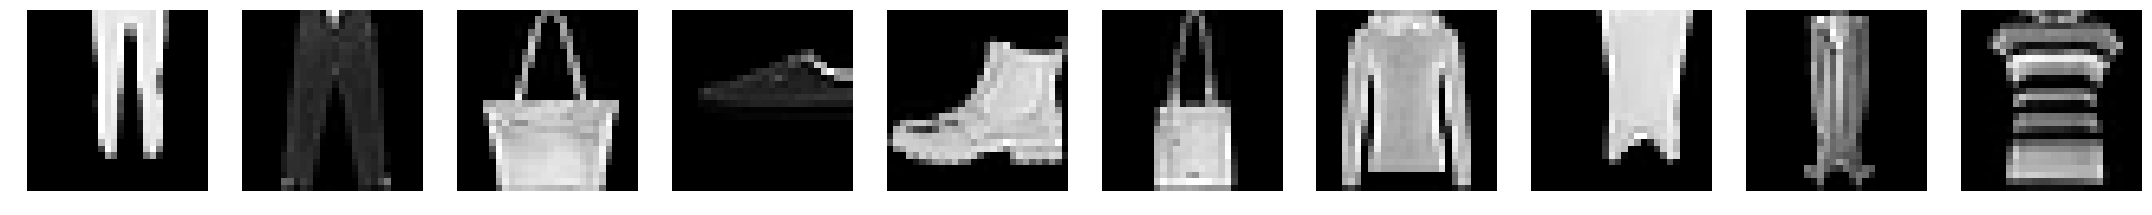

In [6]:
# Data Augmentation
augmentedImgs = np.zeros((len(X_train_after_split), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
augmentedLabels = np.zeros((Y_train_after_split.shape), dtype=np.float32)

seq = iaa.Sequential(
[
    iaa.SomeOf((0,4),
   [
#     iaa.Affine( translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
#         rotate=(-10, 10),deterministic=True),
    iaa.Affine( translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, deterministic=True),
#     iaa.Affine( rotate=(-45, 45), deterministic=True),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5)
   ])
], random_order=True)

seq_det = seq.to_deterministic()
augmentedImgs = seq_det.augment_images(X_train_after_split)
augmentedLabels = np.copy(Y_train_after_split)

listOfAugm = img_utils.showRandomDataFromArray(augmentedImgs)

# combine train images and augmented images
X_train_splited_augmented = np.concatenate((X_train_after_split, augmentedImgs), axis=0)
Y_train_splited_augmented = np.concatenate((Y_train_after_split, augmentedLabels), axis=0)

# Training Phase

In [7]:
# callbacks = [EarlyStopping(patience=2)]
epochsNum = 20
batchSize = 32

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 71s 1ms/step - loss: 0.6656 - acc: 0.7665 - val_loss: 0.3883 - val_acc: 0.8476
Epoch 2/20
48000/48000 [==============================] - 74s 2ms/step - loss: 0.4521 - acc: 0.8370 - val_loss: 0.3810 - val_acc: 0.8512
Epoch 3/20
48000/48000 [==============================] - 76s 2ms/step - loss: 0.4022 - acc: 0.8533 - val_loss: 0.3472 - val_acc: 0.8668
Epoch 4/20
48000/48000 [==============================] - 80s 2ms/step - loss: 0.3645 - acc: 0.8667 - val_loss: 0.3033 - val_acc: 0.8826
Epoch 5/20
48000/48000 [==============================] - 85s 2ms/step - loss: 0.3388 - acc: 0.8760 - val_loss: 0.2941 - val_acc: 0.8922
Epoch 6/20
48000/48000 [==============================] - 84s 2ms/step - loss: 0.3276 - acc: 0.8817 - val_loss: 0.2971 - val_acc: 0.8898
Epoch 7/20
48000/48000 [==============================] - 82s 2ms/step - loss: 0.3113 - acc: 0.8854 - val_loss: 0.3052 - val_acc

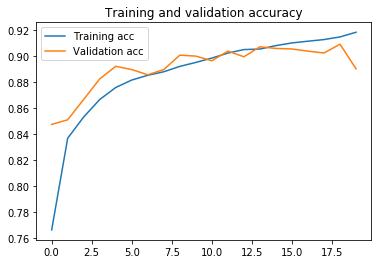

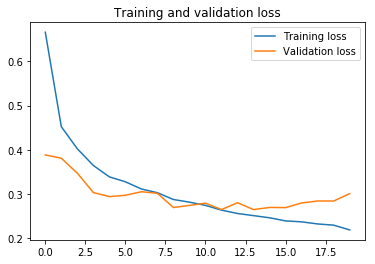

In [16]:
# Train model - Naive
history = model.fit(X_train_after_split, Y_train_after_split, validation_data=(X_val, Y_val), batch_size=batchSize, 
                    epochs=epochsNum)
model_json = model.to_json()
with open("FashiomMNIST0.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("FashiomMNIST0.h5")
print("Saved model to disk")

with open('FashiomMNIST0_hisotry', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)    
    
    # summarize history for loss and accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Train on 96000 samples, validate on 12000 samples
Epoch 1/20
96000/96000 [==============================] - 159s 2ms/step - loss: 0.5916 - acc: 0.7896 - val_loss: 0.2614 - val_acc: 0.9028
Epoch 2/20
96000/96000 [==============================] - 160s 2ms/step - loss: 0.4815 - acc: 0.8252 - val_loss: 0.2882 - val_acc: 0.8950
Epoch 3/20
96000/96000 [==============================] - 159s 2ms/step - loss: 0.4504 - acc: 0.8359 - val_loss: 0.2707 - val_acc: 0.8977
Epoch 4/20
96000/96000 [==============================] - 162s 2ms/step - loss: 0.4321 - acc: 0.8409 - val_loss: 0.2756 - val_acc: 0.9031
Epoch 5/20
96000/96000 [==============================] - 164s 2ms/step - loss: 0.4173 - acc: 0.8468 - val_loss: 0.2695 - val_acc: 0.8985
Epoch 6/20
96000/96000 [==============================] - 164s 2ms/step - loss: 0.4022 - acc: 0.8526 - val_loss: 0.2930 - val_acc: 0.8972
Epoch 7/20
96000/96000 [==============================] - 165s 2ms/step - loss: 0.3953 - acc: 0.8556 - val_loss: 0.2848 - 

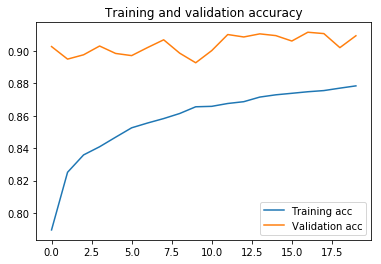

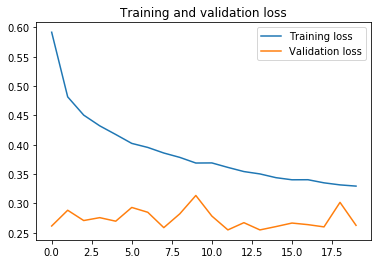

In [17]:
# Train model - With Augmentations
history = model.fit(X_train_splited_augmented, Y_train_splited_augmented, validation_data=(X_val, Y_val), 
                    batch_size=batchSize, epochs=epochsNum)

model_json = model.to_json()
with open("FashiomMNIST0Augm.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("FashiomMNIST0Augm.h5")
print("Saved model to disk")

with open('FashiomMNIST0Augm_hisotry', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)    
    
    
# summarize history for loss and accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
Y_pred = model.predict(X_test)
Y_predClasses = np.argmax(Y_pred, axis =1)
Y_predClasses = Y_predClasses.reshape(Y_test.shape)

score = model.evaluate(x=X_test, y=to_categorical(Y_test))
print(score)

10000/10000 [==============================] - 5s 499us/step
[0.24894921602904796, 0.9161]


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Prediction Analysis

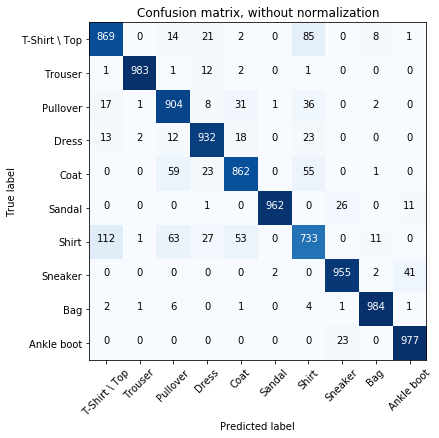

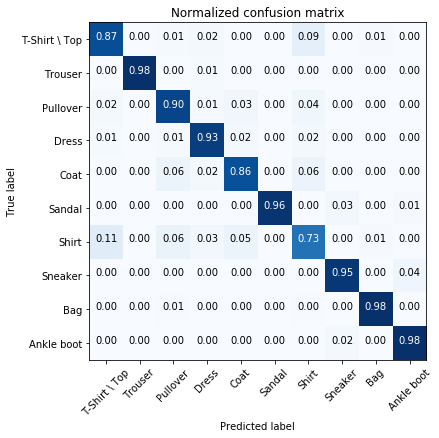

In [20]:
classNames = originalClasses.values()
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, Y_predClasses)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=classNames,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=classNames, normalize=True,
                      title='Normalized confusion matrix')

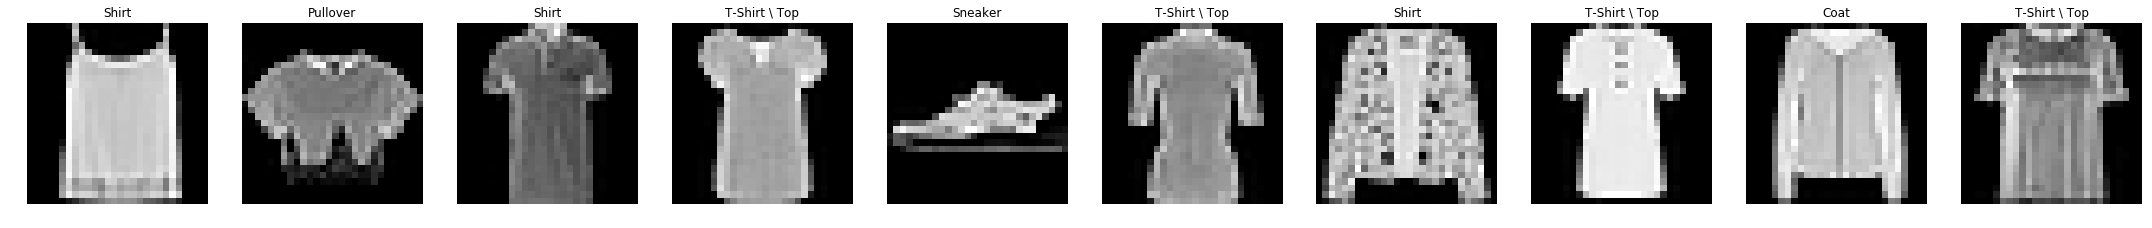

In [21]:
"""Wrong Classsifications"""
wrongCond = Y_predClasses != Y_test
wrongCond = wrongCond.reshape(len(wrongCond))
wrongPredictions = Y_predClasses[wrongCond]
wrongPredictionsData = X_test[wrongCond, :, :]
showRandomDataFromArray(wrongPredictionsData, labels=originalClasses, cls=wrongPredictions)